In [33]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
from sklearn.metrics import mean_squared_error
from smt.explainability_tools import ShapFeatureImportanceDisplay, ShapDisplay
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import time
import numpy as np
import pandas as pd
import shap


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [31]:
"""Problem definition"""
# Design space
ds = DesignSpace([
    CategoricalVariable([
        "1", 
        "2", 
        "3", 
        "4", 
        "5", 
        "6", 
        "7", 
        "8", 
        "9", 
        "10", 
        "11", 
        "12",
    ]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])


# Objective function
def y(X):
    listI = [
        0.0833,
        0.139,
        0.380,
        0.0796,
        0.133,
        0.363,
        0.0859,
        0.136,
        0.360,
        0.0922,
        0.138,
        0.369,
        ]
    
    I = np.int64(X[0])
    L = X[1]
    S = X[2]
    Ival = listI[I]

    E = 200e9
    P = 50e3

    y = (P * L**3) / (3 * E * S**2 * Ival) 

    return y

f_obj = y

# Create training and testing data
n_data = 500
n_train = int(0.8 * n_data)
n_test = n_data - n_train
xdoe, _ = ds.sample_valid_x(n_data)
y_doe = [f_obj(xdoe[i]) for i in range(len(xdoe))]

X_tr, y_tr = xdoe[:n_train, :], y_doe[:n_train]
X_te, y_te = xdoe[n_train:, :], y_doe[n_train:]
y_tr, y_te = np.array(y_tr), np.array(y_te)
inverse_categories_map = {0: {i: f"{i+1}" for i in range(12)}}

X_tr_df = pd.DataFrame(X_tr, columns=["I", "L", "S"])
X_te_df = pd.DataFrame(X_te, columns=["I", "L", "S"])

X_tr_df["I"] = X_tr_df["I"].apply(lambda x: inverse_categories_map[0][x])
X_te_df["I"] = X_te_df["I"].apply(lambda x: inverse_categories_map[0][x])
X_tr_df["I"] = X_tr_df["I"].astype("category")
X_te_df["I"] = X_te_df["I"].astype("category")

model = XGBRegressor(enable_categorical=True)
model = model.fit(X_tr_df, y_tr)
y_pred = model.predict(X_te_df)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")



RMSE: 0.0002
rRMSE: 0.2182


In [38]:
explainer = shap.Explainer(model.predict, np.array(X_tr_df))
shap_values = explainer(X_tr_df)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


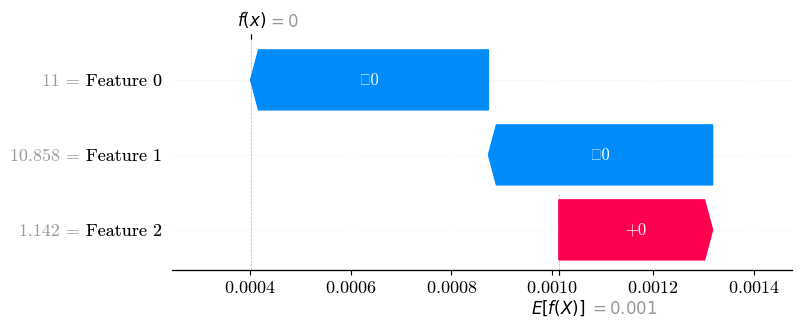

In [36]:
shap.plots.waterfall(shap_values[0])